# Doublet Analysis

Project ArchR Doublet scores over UMAP with all cells (no doublet removal) to estimate doublet population.

In [1]:
library(GenomicRanges)
library(ggplot2)
library(scales)

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The

In [2]:
# Metadata file from previous run (without doublet removal)
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 68916     6

,barcode,sample,umap1,umap2,cells,cluster
,<fct>,<fct>,<dbl>,<dbl>,<chr>,<int>
D0_AAACAACGACGATTAC,AAACAACGACGATTAC,D0,6.565758,-8.649868,D0_AAACAACGACGATTAC,5
D0_AAACAACGAGCGCACT,AAACAACGAGCGCACT,D0,5.604522,-7.835411,D0_AAACAACGAGCGCACT,5
D0_AAACACGCTACGCCAC,AAACACGCTACGCCAC,D0,5.130516,-7.593246,D0_AAACACGCTACGCCAC,5
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,4.926843,-8.365463,D0_AAACACGCTAGTACGG,6
D0_AAACACGCTCCTCAAA,AAACACGCTCCTCAAA,D0,6.056337,-5.647577,D0_AAACACGCTCCTCAAA,5


In [68]:
doublet_scores = data.frame(sample_barcode=c(), score=c())

# not using doublet scores for D0 and iPSC as they are homogenous populations
for (d in c("D2", "D4", "D6", "D8", "D10", "D12", "D14")) {
    cur_rds = readRDS(sprintf("./QualityControl/%s/%s-Doublet-Summary.rds", d, d))
    cur_doublet_scores = cur_rds$doubletResults$doubletScoreUMAP
    cur_doublet_scores = data.frame(sample_barcode=sub("#", "_", names(cur_doublet_scores)), 
                                    score=cur_rds$doubletResults$doubletScoreUMAP,
                                   enrich=cur_rds$doubletResults$doubletEnrichUMAP)
    
    doublet_scores = rbind(doublet_scores, cur_doublet_scores)
}

rownames(doublet_scores) = doublet_scores$sample_barcode
doublet_scores$sample_barcode = NULL

In [69]:
head(doublet_scores)
dim(doublet_scores)

,score,enrich
,<dbl>,<dbl>
D2_CGTGCCAGACGTTATG,0.8671611,1.66
D2_GGATTTGACGAACGTG,0.0000000,1.14
D2_AGCGCAAGAGATAGCG,0.0000000,0.50
D2_CACGAATTGTTGCGTA,0.0000000,0.62
D2_CAAGAGTCTTTTGGGT,6.1311026,2.06
D2_CGACCTTACTTTCGCC,0.0000000,0.88


[1] 68329     2

In [70]:
dscores = doublet_scores[rownames(metaData), ]
dscores$score[is.na(dscores$score)] = 0
dscores$enrich[is.na(dscores$enrich)] = 0

In [71]:
quantile(dscores$score, 0.95)
quantile(dscores$enrich, 0.95)

95% 
18.82669

95% 
2.82

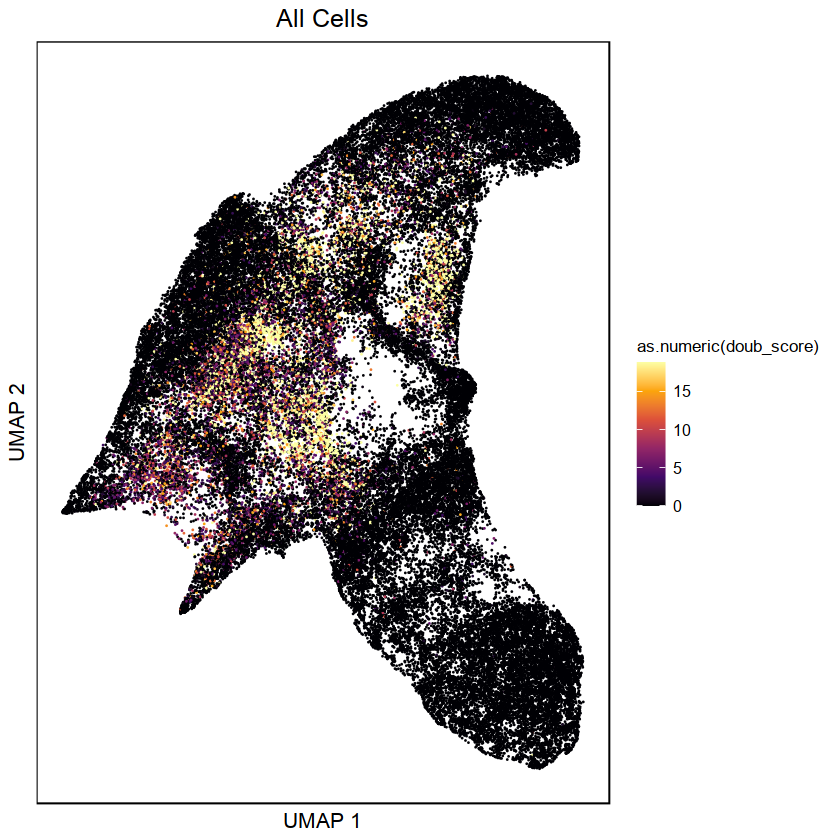

In [72]:
cur_score = dscores$score
df = data.frame(metaData, doub_score=cur_score)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.5, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=as.numeric(doub_score))) +
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(quantile(cur_score, 0.05), 
                               quantile(cur_score, 0.95)), 
                      oob=squish, option = "B") +
theme_classic() +
ggtitle("All Cells") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5))

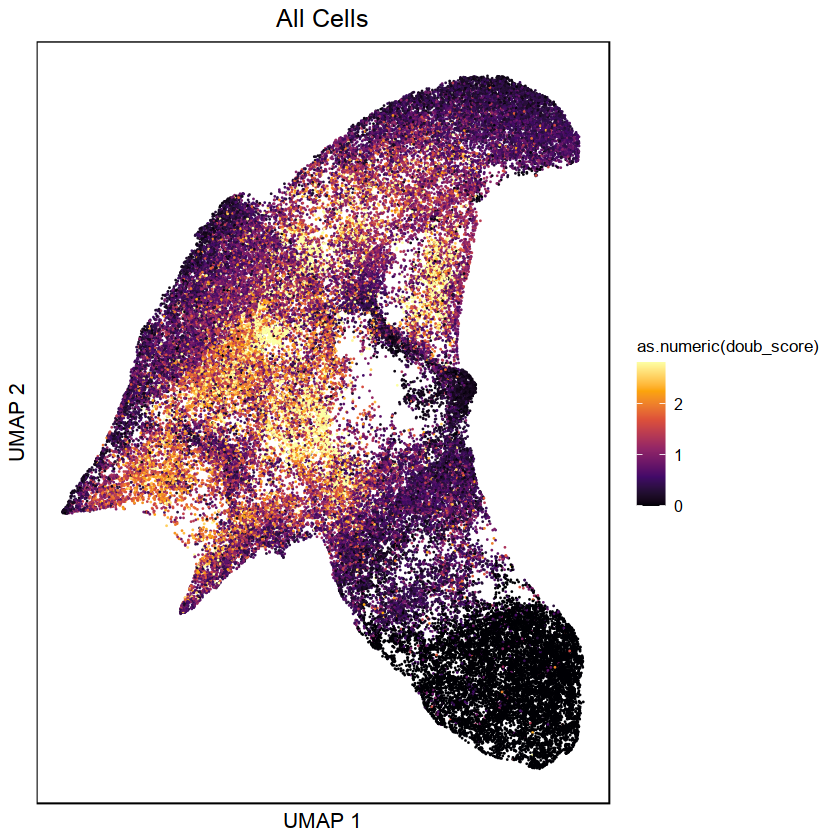

In [73]:
cur_score = dscores$enrich
df = data.frame(metaData, doub_score=cur_score)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.5, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=as.numeric(doub_score))) +
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(quantile(cur_score, 0.05), 
                               quantile(cur_score, 0.95)), 
                      oob=squish, option = "B") +
theme_classic() +
ggtitle("All Cells") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5))

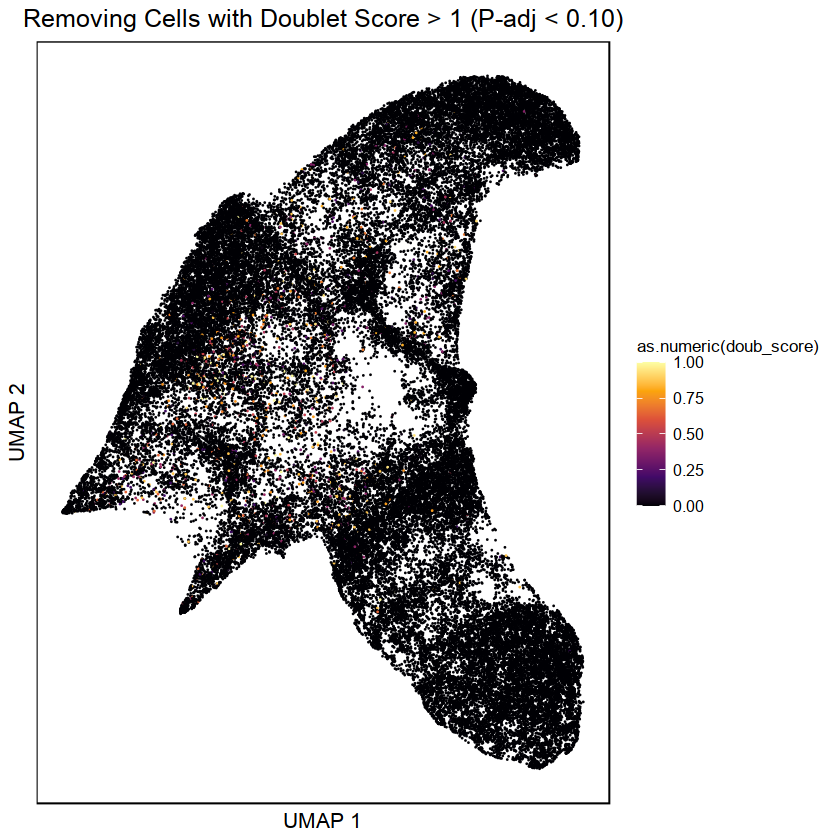

In [74]:
CUTOFF = 1
cur_score = dscores$score

df = data.frame(metaData[cur_score<=CUTOFF,], doub_score=cur_score[cur_score<=CUTOFF])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.5, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=as.numeric(doub_score))) +
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(0, CUTOFF), 
                      oob=squish, option = "B") +
theme_classic() +
ggtitle(sprintf("Removing Cells with Doublet Score > %d (P-adj < %.2f)", CUTOFF, 10^(-CUTOFF))) +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
    panel.border = element_rect(colour = "black", fill=NA, size=0.5))

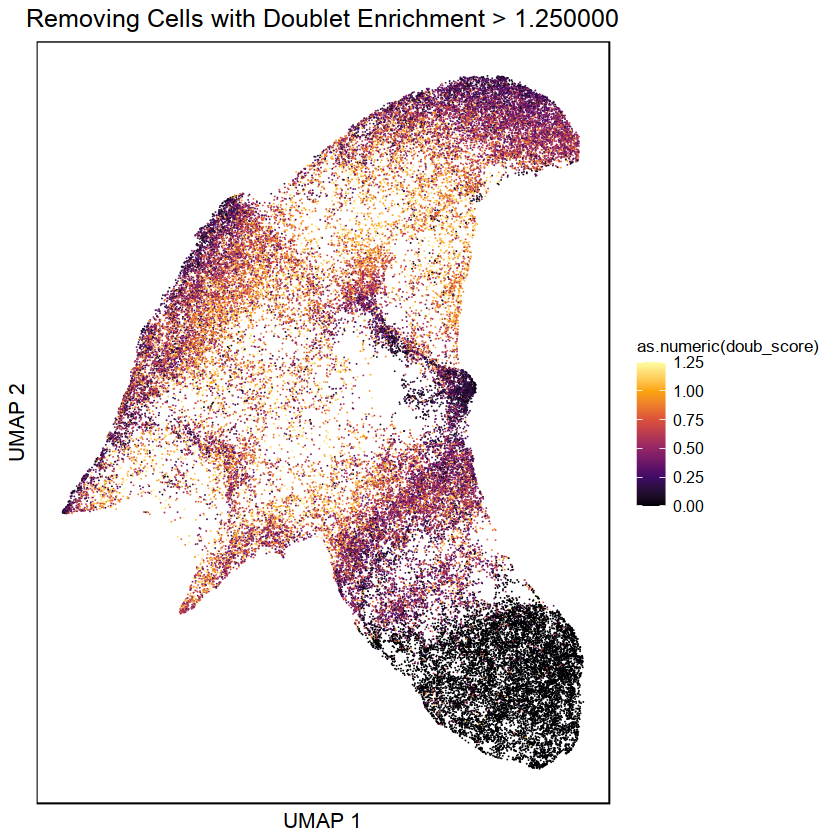

In [124]:
CUTOFF = 1.25
cur_score = dscores$enrich

df = data.frame(metaData[cur_score<=CUTOFF,], doub_score=cur_score[cur_score<=CUTOFF])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.25,stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=as.numeric(doub_score))) +
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(0, CUTOFF), 
                      oob=squish, option = "B") +
theme_classic() +
ggtitle(sprintf("Removing Cells with Doublet Enrichment > %f", CUTOFF)) +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
    panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [121]:
sum(dscores$score<=1)
sum(dscores$enrich<=1.25)

[1] 57457

[1] 51058

In [96]:
# breakdown by cluster
doub_counts = table(metaData[dscores$enrich>1.25, "cluster"])
all_counts = table(metaData[metaData$cluster %in% names(doub_counts), "cluster"])

sort(doub_counts/all_counts)


           6            5           10            3            4           16 
0.0009595087 0.0026631158 0.0262254902 0.0730452675 0.1064345193 0.1399317406 
           2            1           11            9            7           14 
0.2046833122 0.2158351410 0.3190533253 0.3240313653 0.3666015625 0.4177497215 
           8           12           15           17           13 
0.4664127424 0.5439304564 0.5466491459 0.5874254245 0.8204344874 

## Write Barcodes

The above analyses were done on barcodes selected in a previous run. However, will write down all barcodes that pass multiple criteria.

In [97]:
# pull nFrags and TSS enrichment for all doublets
qc_scores = data.frame(sample_barcode=c(), nFrags=c(), tss=c())

for (d in c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14", "iPSC")) {
    cur_rds = readRDS(sprintf("./QualityControl/%s/%s-Pre-Filter-Metadata.rds", d, d))
    cur_qc = data.frame(sample_barcode=sub("#", "_", cur_rds$cellNames),
                        nFrags = cur_rds$nFrags,
                        tss = cur_rds$TSSEnrichment,
                       sample=d)
    qc_scores = rbind(qc_scores, cur_qc)
}

rownames(qc_scores) = qc_scores$sample_barcode
qc_scores$sample_barcode = NULL

In [98]:
# add doublet enrichment
qc_scores$doublet_enrich = doublet_scores[rownames(qc_scores), "enrich"]
qc_scores$doublet_enrich[is.na(qc_scores$doublet_enrich)] = 0

In [99]:
dim(qc_scores)
head(qc_scores)

[1] 92603     4

,nFrags,tss,sample,doublet_enrich
,<dbl>,<dbl>,<fct>,<dbl>
D0_CCCATGTACAGCTTTG,93719,12.422,D0,0
D0_GGTTCCTTGCGAGTTT,92405,11.924,D0,0
D0_AAGGTAATGACGCGAA,91264,13.197,D0,0
D0_CTAGCTCACCCGTTAA,89717,13.101,D0,0
D0_CAGTGGAGAGCTCTTC,88640,12.291,D0,0
D0_CAACAACACCCTATCC,88105,13.580,D0,0


In [136]:
TSS = 6
NFRAG = 1000
ENRICH = 1.25

In [137]:
criteria = (qc_scores$nFrags>NFRAG)&(qc_scores$tss>TSS)&(qc_scores$doublet_enrich<=ENRICH)
sum(criteria)

[1] 65357

In [127]:
table(qc_scores[criteria, "sample"])


   D0    D2    D4    D6    D8   D10   D12   D14  iPSC 
11202  6676  5526  7685  7550  1234  3058 14997  7429 

In [128]:
DIR = sprintf("./barcodeLists/20210713_ArchR_nFrags_%d_TSS_%d_doublet_enrichment_%.2f", NFRAG, TSS, ENRICH)
DIR

[1] "./barcodeLists/20210713_ArchR_nFrags_1000_TSS_6_doublet_enrichment_1.25"

In [129]:
subset = qc_scores[criteria, ]
dim(subset)

[1] 65357     4

In [130]:
write.table(subset, sprintf("%s/scores.tsv", DIR),
           sep='\t', quote=F, row.names=T, col.names=T)

In [131]:
for (x in unique(qc_scores$sample)) {
    cur_barcodes = lapply(strsplit(rownames(subset[(subset$sample==x), ]), "_"), "[[", 2)
    write.table(unlist(cur_barcodes),
                sprintf("%s/%s.barcodes.txt", DIR, x), 
                row.names=F,
                col.names=F,
                quote=F)
}

In [59]:
# OLD

# write barcodes with zero doublet score (most stringent) for replotting UMAP
# for (x in unique(metaData$sample)) {
#     cur_barcodes = metaData[(metaData$sample==x)&(dscores==0), "barcode"]
#     write.table(unlist(cur_barcodes),
#                 sprintf("../20200206_pmat_snapATAC/barcodeLists/20200531_ArchR_doublet_score_0/%s.barcodes.txt", x), 
#                 row.names=F,
#                 col.names=F,
#                 quote=F)
# }

---

In [122]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
[1] scales_1.1.0         ggplot2_3.3.3        GenomicRanges_1.38.0
[4] GenomeInfoDb_1.22.1  IRanges_2.20.2       S4Vectors_0.24.4    
[7] BiocGenerics_0.32.0 

loaded via a namespace (and not attached):
 [1] pillar_1.4.6           compiler_3.6.3         XVector_0.26.0       